In [16]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
from glob import glob 

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.map_coordinates.html

import scipy 
from scipy import ndimage


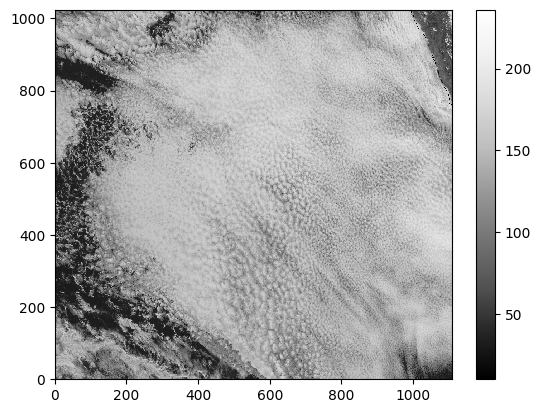

In [17]:


# Define the path to the directory containing the images
path = 'C:\\Users\\ratynski\\Documents\\Python_Projects\\stratocu_waves-main\\DATA\\2022_09_06\\'
# Use glob to find the images in the specified path
fnames = np.sort(glob(path + '*9_06*png'))
images = []

# Read the images and process them
for i, fname in enumerate(fnames):
    img = imageio.v2.imread(fname)
    red = np.flipud(img[:, 400:, 0])
    images.append(red)  # Just red channel, just 400:end in the x dir, flip y

# Plot the first processed image
plt.pcolormesh(images[0], cmap='Greys_r')
plt.colorbar()
plt.show()


In [18]:
# Get the dimensions of the image
height, width = red.shape[:2]

# Create 2D arrays of x and y
x = np.arange(width)
y = np.arange(height)

# Create a meshgrid of x and y
X, Y = np.meshgrid(x, y)


# Pixel size: nominal for MKS units to pixel units 
DX = 2000             # m, pixel size (nominal)

# Xm and Ym are Coordinates in meters, distances measured from central point of image
Xm = (X-X.mean())*DX
Ym = (Y-Y.mean())*DX 

## Wave parameters for warping and modulating an image
"In one period, 7–9 October 2008, the waves modulated cloud-top-height by up to 400 m peak-to-trough, propagating perpendicular to the synoptic boundary layer flow with phase speed 15.3 m s−1, period ∼1 h and horizontal wavelength 55 km. The gravity waves were observed to be non-dispersive. “ from https://doi.org/10.1002/qj.1952

For a wave moving toward 45 degrees (northeast), define k and l as positive (sin and cos of nav angle). Let's take z = sin( k(x-ct) + l(y-ct) ) which is indeed moving NEward with time. Then u and v are both positive at z crests (sketch it). That means dx and dy are positve when time is 1/4 period later, or when 90deg of phase have been subtracted since t appears with a negative sign in the formula for phase (x-ct).

In [19]:
# One wave packet 
cphase = 14            # m/s
wavelength = 150*1000. # meters
period = wavelength/cphase 
direction = 225       # navigation angle of FROM direction in degrees (225 = FROM SW, toward NE) 
zamplitude = 100      # meters, vertical displacement
PBLdepth = 1000       # m, divergent winds assumed to be constant through this layer  

# Wavenumbers computed from wavelengths and direction, units radians per meter
k = 2*np.pi/wavelength * np.sin( (direction) *np.pi/180 )   
l = 2*np.pi/wavelength * np.cos( (direction) *np.pi/180 )   

# Amplitude modulation by a big smooth Gaussian 
packet_center_x = -400*1000  # meters, from middle of Xm, Ym coordinates  
packet_center_y = 400*1000   # meters, from middle of Xm, Ym coordinates  
packet_width_x  = 400*1000.  # meters
packet_width_y  = 300*1000.  # meters
Ampwindow = np.exp(-( ((Xm-packet_center_x)/packet_width_x)**2 + \
                      ((Ym-packet_center_y)/packet_width_y)**2 )) 
     
#plt.pcolormesh(Ampwindow); plt.colorbar()

In [20]:
# A second wave packet 
cphase2 = 20            # m/s
wavelength2 = 100*1000. # meters
period2 = wavelength2/cphase2 
direction2 = 140       # navigation angle of FROM direction in degrees (225 = FROM SW, toward NE) 
zamplitude2 = 50      # meters, vertical displacement
PBLdepth2 = 1000       # m, divergent winds assumed to be constant through this layer  

# Wavenumbers computed from wavelengths and direction, units radians per meter
k2 = 2*np.pi/wavelength2 * np.sin( (direction2) *np.pi/180 )   
l2 = 2*np.pi/wavelength2 * np.cos( (direction2) *np.pi/180 )   

# Amplitude modulation by a big smooth Gaussian 
packet_center_x2 = 400*1000  # meters, from middle of Xm, Ym coordinates  
packet_center_y2 = 100*1000   # meters, from middle of Xm, Ym coordinates  
packet_width_x2  = 200*1000.  # meters
packet_width_y2  = 600*1000.  # meters
Ampwindow2 = np.exp(-( ((Xm-packet_center_x2)/packet_width_x2)**2 + \
                      ( (Ym-packet_center_y2)/packet_width_y2)**2 )) 

### Animation displays for time-dependent warped imagery texture

In [21]:
# Constants for this animation 
time_steps = 10            # Number of time steps 
time_resolution = 1800     # seconds, images are half an hour apart

# The resulting image arrays, for animation 
grid = np.zeros((height, width, time_steps))


# BUILD THE WARPED MODULATED IMAGES AT EACH TIME

for it in range(time_steps):
    t = it*time_resolution     # t is in seconds 

# dz measures vertical displacements: let's choose the sine function. Two packets 
    dz = zamplitude \
         * np.sin( k*(Xm - cphase*t)+l*(Ym - cphase*t) ) *Ampwindow 
    dz2 = zamplitude2 \
         * np.sin( k2*(Xm - cphase2*t)+l2*(Ym - cphase2*t) ) *Ampwindow2

# wave dx and dy are 90deg behind phase with dz, prop. to wavelength. 
# DIRECTION: For 45deg (wave going NE), k>0,l>0, dx>0,dy>0 (sketch it). 

    dxy = (zamplitude/PBLdepth)*wavelength \
          * np.sin( k*(Xm - cphase*t)+l*(Ym - cphase*t) -np.pi/2.) /DX
    dx = dxy * np.sin(direction *np.pi/180.) *Ampwindow # why /2? because it is too strong. Pixel units?? 
    dy = dxy * np.cos(direction *np.pi/180.) *Ampwindow

    dxy2= (zamplitude2/PBLdepth2)*wavelength2 \
          * np.sin( k2*(Xm - cphase2*t)+l2*(Ym - cphase2*t) -np.pi/2.) /DX
    dx2= dxy2* np.sin(direction2 *np.pi/180.) *Ampwindow2 
    dy2= dxy2* np.cos(direction2 *np.pi/180.) *Ampwindow2

# Warping by transporting pixels in original red image, wrapping (periodic) for now. SUBTRACT dy and dx in argument. 
    grid[:,:,it] = ndimage.map_coordinates(images[it],[Y-dy-dy2, X-dx-dx2])  

# Modulate (multiply) albedo by a wavy pattern (vertical displacements, 
#           make consistent with xmotion and ymotion arrays above) 
    grid[:,:,it] *= (1 + dz /PBLdepth  *5) 
    grid[:,:,it] *= (1 + dz2/PBLdepth2 *5) 

maxvalue = grid.max()
maxvalue

309.58694301653907

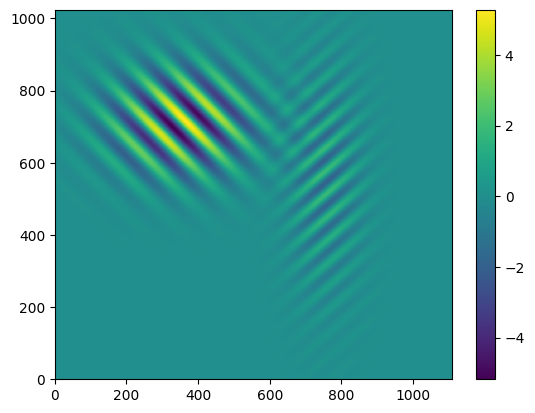

In [22]:
plt.pcolormesh(dy+dy2); plt.colorbar(); # pixels units -- surprising that 7 pixels make such a huge warp?

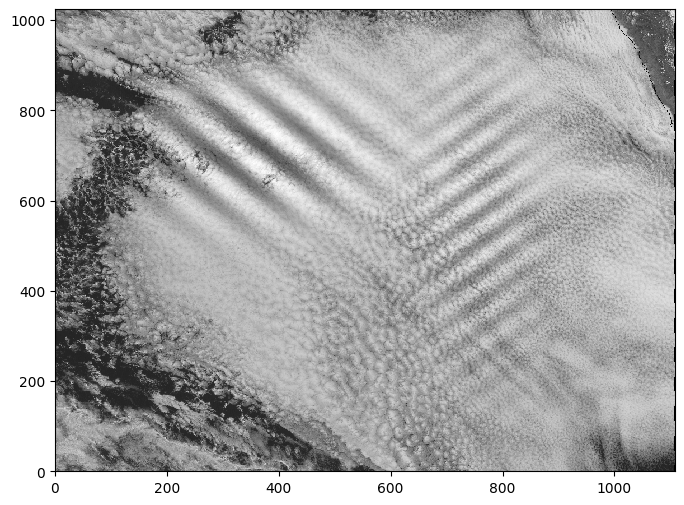

In [23]:
plt.figure(figsize=(8,6))
plt.pcolormesh(grid[:,:,0], cmap='Greys_r')

# Use the Wave Rose code to try and get the directions correct

In [24]:
from Eof_functions import *

kl_inf = 0.00666666666 # 300 Km
kl_sup = 0.06666666666 # 30 Km
w_step=0.01 # Default value

c_inf = 12 # Default value
c_sup = 17 # Default value

frames = grid # All frames of the animation

overlap_=0.5   # Default value
strength_=0.5 # Default value

all_directions, all_amplitudes, wavenumber_values = analyze_frame_SFilt(frames,0, square_size=256, overlap=overlap_, strength=strength_, kl_cutoff_inf=kl_inf, 
                  kl_cutoff_sup=kl_sup, wavenumber_step=w_step, c_cutoff_inf=c_inf, c_cutoff_sup=c_sup, Filter = False, log=True, plot_condition=False)

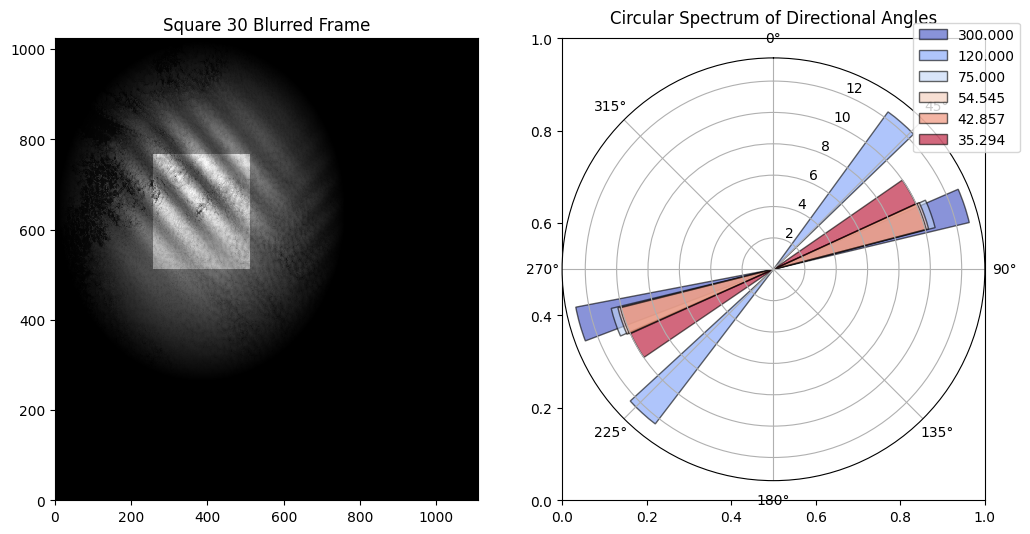

In [25]:
# Define other parameters used in the function

square_sz = 256 # Default value (Don't touch it, as it needs to be the same as for the analyze_frame function)
square_nb = 30  # Specify the square number you want to visualize

visualize_results_SFilt(frames,0, all_directions, all_amplitudes, wavenumber_values, square_number=square_nb, square_size=square_sz, overlap=overlap_, strength=strength_, kl_cutoff_inf=kl_inf, 
                  kl_cutoff_sup=kl_sup, c_cutoff_inf=c_inf, c_cutoff_sup=c_sup, Filter = False, Amp=False, log=True, Km=True)

In [26]:
kl_inf = 0.00666666666 # 300 Km
kl_sup = 0.06666666666 # 30 Km
w_step=0.01 # Default value

c_inf = 12 # Default value
c_sup = 17 # Default value

# The data format is (L,K,F)

frames = grid # All frames of the animation
frame = grid[:,:,0] # First warped frame of the animation

overlap_=0.5   # Default value
strength_=0.5 # Default value

all_directions, all_amplitudes, wavenumber_values = analyze_frame_SFilt(frames,0, square_size=256, overlap=overlap_, strength=strength_, kl_cutoff_inf=kl_inf, 
                  kl_cutoff_sup=kl_sup, wavenumber_step=w_step, c_cutoff_inf=c_inf, c_cutoff_sup=c_sup, Filter = True, log=True, plot_condition=False)

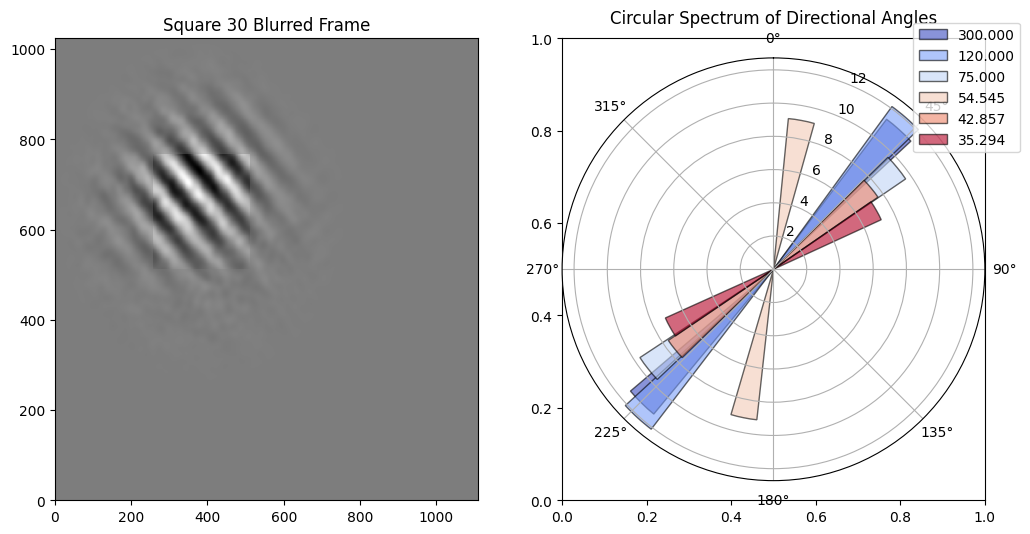

In [27]:
# Define other parameters used in the function

square_sz = 256 # Default value (Don't touch it, as it needs to be the same as for the analyze_frame function)
square_nb = 30  # Specify the square number you want to visualize

visualize_results_SFilt(frames,0, all_directions, all_amplitudes, wavenumber_values, square_number=square_nb, square_size=square_sz , overlap=overlap_, strength=strength_, kl_cutoff_inf=kl_inf, 
                  kl_cutoff_sup=kl_sup, c_cutoff_inf=c_inf, c_cutoff_sup=c_sup, Filter = True, Amp=False, log=True)

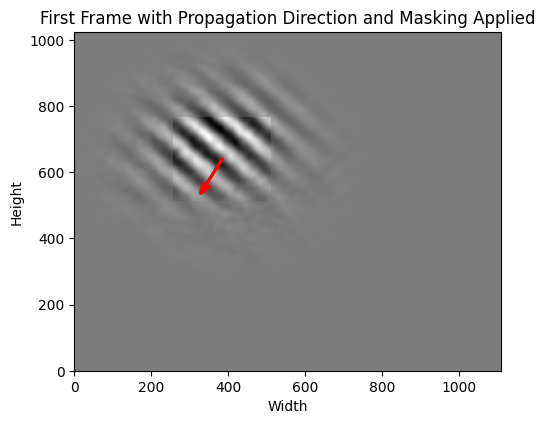

Propagation direction: 208.15 degrees
Best Wavenumber: 0.04291666666, Best Amplitude: 793.2974207417983, Refinement Steps: 4


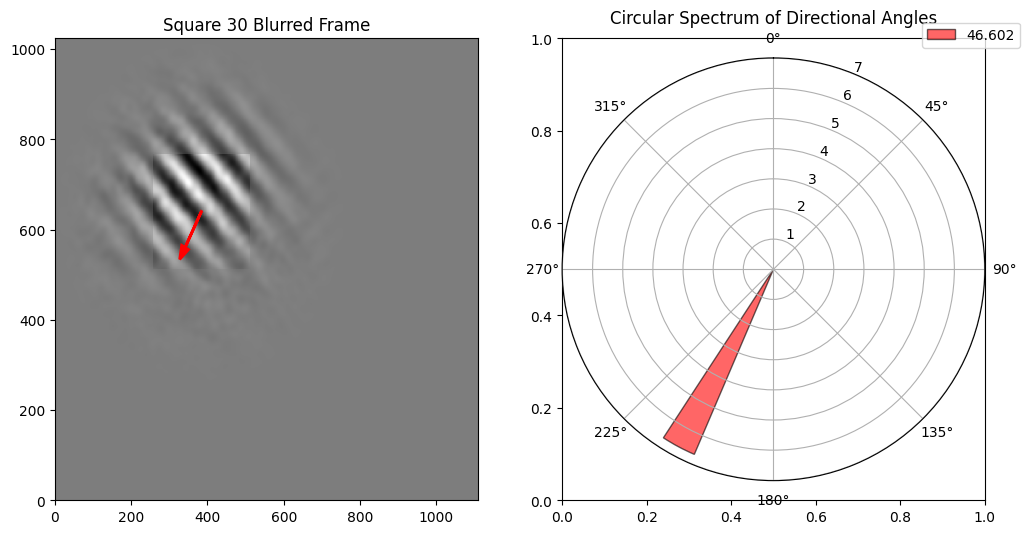

In [35]:
# Example usage with synthetic data
frames = grid 
frame_index = 0  # Index of the frame to analyze 

square_number = 30  # Specify the square number to analyze

kl_inf = 0.00666666666 # 300 Km
kl_sup = 0.06666666666 # 30 Km
cf_inf = 12 
c_sup = 17 

strength_ = 0.5
overlap_ = 0.5

# Compute the propagation direction for a specific square
propagation_direction, avg_shift, mask, square_coords = infer_propagation_direction(frames, square_number=square_number, square_size=256, strength=strength_, overlap=overlap_, kl_cutoff_inf=kl_inf, kl_cutoff_sup=kl_sup, c_cutoff_inf=cf_inf, c_cutoff_sup=c_sup)

# propagation_direction = 225

# Filter the frames based on the same parameters
frames_disp = filter_frames(frames, kl_inf, kl_sup, cf_inf, c_sup)
frame_height, frame_width, num_frames = frames.shape

# Apply the mask to the first frame for display
masked_first_frame = frames_disp[:, :, 0] * mask

# Plot the first frame with the same masking applied and the propagation direction
plt.figure(figsize=(5*1.1, 4*1.1))
plt.pcolormesh(masked_first_frame, cmap='gray')
plt.title('First Frame with Propagation Direction and Masking Applied')

# Calculate the arrow starting point and length
i, j, square_size = square_coords
start_x = j + square_size // 2
start_y = i + square_size // 2
propagation_angle_rad = np.deg2rad(propagation_direction)
arrow_length = 50  # Length of the arrow for visualization
end_x = start_x + avg_shift[1] * 0.2  # Scale factor for visualization
end_y = start_y + avg_shift[0] * 0.2  # Scale factor for visualization


# Plot the arrow
plt.arrow(start_x, start_y, end_x - start_x, end_y - start_y, color='red', head_width=20, head_length=30, linewidth=2)
plt.xlabel('Width')
plt.ylabel('Height')
plt.xlim(0, frame_width)
plt.ylim(0, frame_height)
plt.show()

# Print the propagation direction in degrees
# propagation_direction=propagation_direction % 360
print(f'Propagation direction: {propagation_direction:.2f} degrees')

best_wavenumber, best_amplitude, refinement_steps = find_best_wavenumber_match(frames, frame_index, propagation_direction, square_size=256, strength=strength_, overlap=overlap_, kl_cutoff_inf=kl_inf, kl_cutoff_sup=kl_sup, wavenumber_step=0.01, c_cutoff_inf=cf_inf, c_cutoff_sup=c_sup, Filter=True)
print(f"Best Wavenumber: {best_wavenumber}, Best Amplitude: {best_amplitude}, Refinement Steps: {refinement_steps}")

visualize_results_SFilt_Best_Wavenumber(frames, frame_index, propagation_direction, best_wavenumber, best_amplitude, avg_shift,
                      square_number, square_size=256, strength=strength_, overlap=overlap_,
                       kl_cutoff_inf=0.00666666666, kl_cutoff_sup=0.06666666666, c_cutoff_inf=12, 
                       c_cutoff_sup=17, Filter=True,Amp=False, log=True, Km=True)


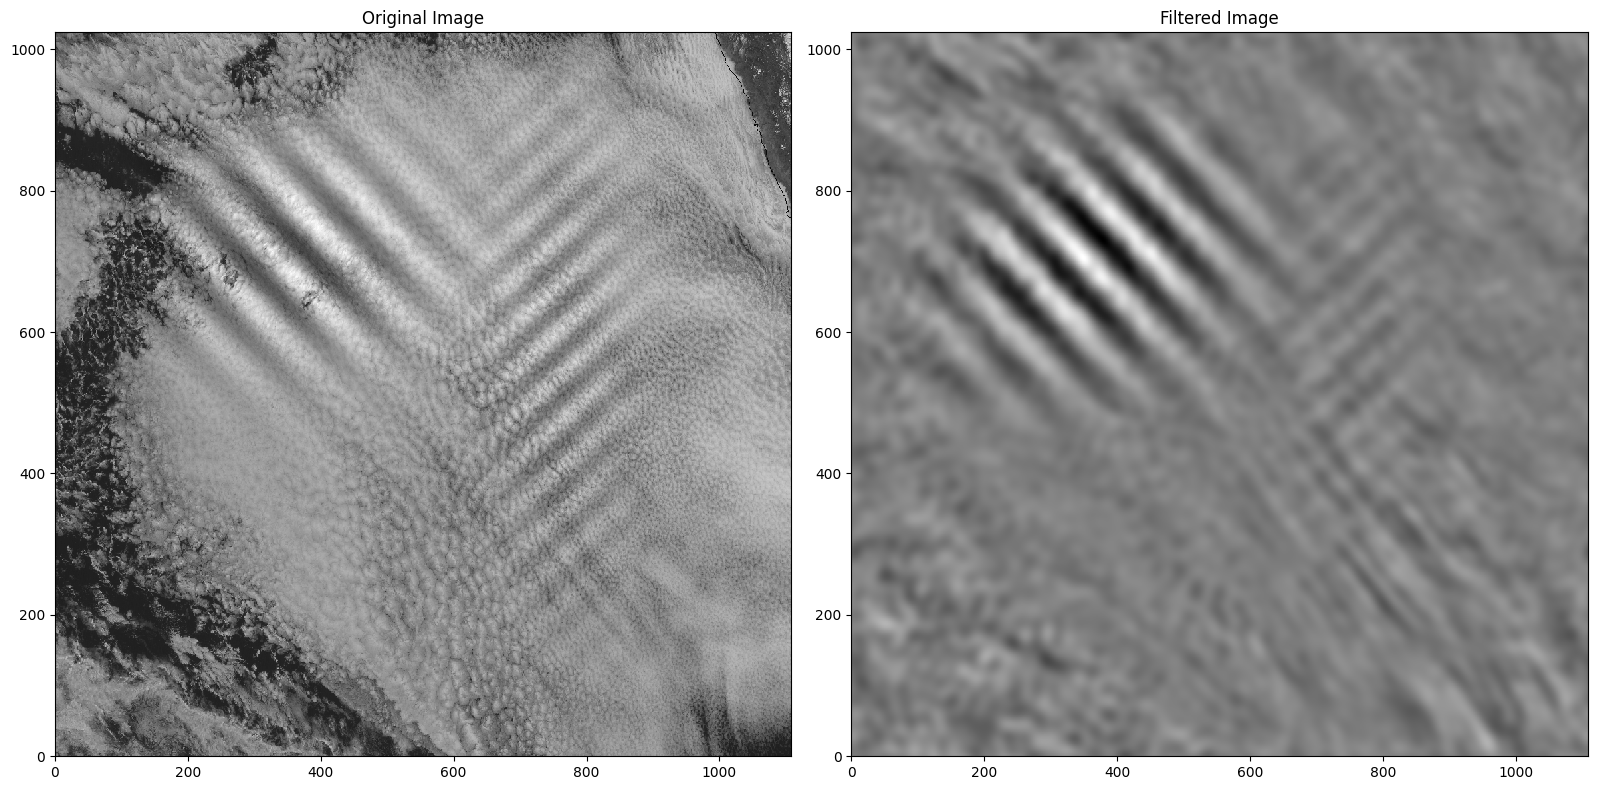

In [29]:
kl_inf = 0.00666666666 # 300 Km
kl_sup = 0.06666666666 # 30 Km
w_step=0.01 # Default value

c_inf = 12 # Default value is 12
c_sup = 17 # Default value is 17


Visualize_Filter(frames,frame,kl_cutoff_inf=kl_inf,kl_cutoff_sup=kl_sup, c_cutoff_inf=c_inf, c_cutoff_sup=c_sup, Amp=False)

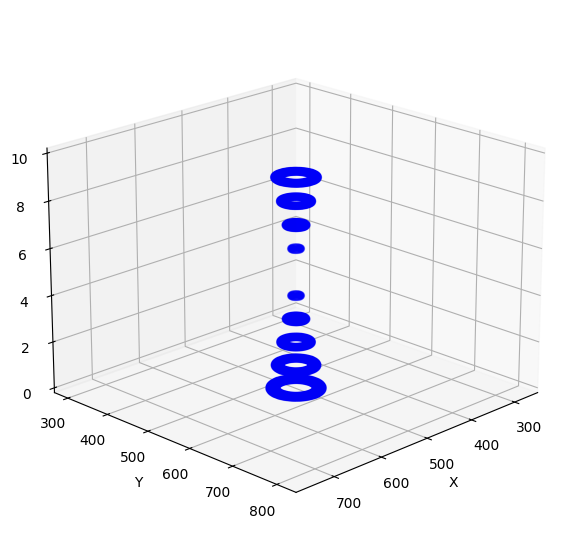

In [30]:
Visualize_Filter_3D(frames,kl_inf = 0.00666666666, kl_sup = 0.06666666666, c_inf = 12, c_sup = 17)

# Display it !

In [ ]:
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 8))  

# Function to initialize the animation 
def init():
    im = ax.pcolormesh(grid[:, :, 0],vmin=0,vmax=maxvalue,cmap='Greys_r');
    plt.title(f'Time Step 0')
    plt.xlabel('X (km)')
    plt.ylabel('Y (km)')
    return [im]

# Function to animate the frames
def animate(it):
    im = ax.pcolormesh(grid[:, :, it],vmin=0,vmax=maxvalue,cmap='Greys_r')
    plt.title(f'Time Step {t}')
    return [im]

# Create an animation
ani = animation.FuncAnimation(fig, animate, init_func=init, frames=grid.shape[2], repeat=True)

# Display the animation in the Jupyter Notebook
HTML(ani.to_jshtml())

In [ ]:
plt.contourf( grid[:,750,:], cmap='Greys_r')

In [ ]:
ani.save('DATA/syn_scwave_warp_modx5.mp4',writer='ffmpeg', fps=5)